In [1]:
#Creating dataframe from json data
import pandas as pd


data = [
{"app": "A", "bid_price": 0.01, "win": 0, "events": 100000}, 
{"app": "A", "bid_price": 0.01, "win": 1, "events": 0}, 
{"app": "A", "bid_price": 0.1, "win": 0, "events": 7000}, 
{"app": "A", "bid_price": 0.1, "win": 1, "events": 3000}, 
{"app": "A", "bid_price": 0.2, "win": 0, "events": 8000000}, 
{"app": "A", "bid_price": 0.2, "win": 1, "events": 2000000}, 
{"app": "A", "bid_price": 0.4, "win": 0, "events": 700000}, 
{"app": "A", "bid_price": 0.4, "win": 1, "events": 300000}, 
{"app": "A", "bid_price": 0.5, "win": 0, "events": 80000}, 
{"app": "A", "bid_price": 0.5, "win": 1, "events": 20000}, 
{"app": "A", "bid_price": 0.75, "win": 0, "events": 7000}, 
{"app": "A", "bid_price": 0.75, "win": 1, "events": 3000}, 
{"app": "A", "bid_price": 1, "win": 0, "events": 400}, 
{"app": "A", "bid_price": 1, "win": 1, "events": 600}, 
{"app": "A", "bid_price": 2, "win": 0, "events": 30}, 
{"app": "A", "bid_price": 2, "win": 1, "events": 70}, 
{"app": "A", "bid_price": 5, "win": 0, "events": 2}, 
{"app": "A", "bid_price": 5, "win": 1, "events": 8}, 
{"app": "A", "bid_price": 9, "win": 0, "events": 0}, 
{"app": "A", "bid_price": 9, "win": 1, "events": 1}
]

df = pd.DataFrame(data)
df.head(10)

,app,bid_price,win,events
0,A,0.01,0,100000
1,A,0.01,1,0
2,A,0.10,0,7000
3,A,0.10,1,3000
4,A,0.20,0,8000000
5,A,0.20,1,2000000
6,A,0.40,0,700000
7,A,0.40,1,300000
8,A,0.50,0,80000
9,A,0.50,1,20000


In [2]:
# Group by bid_price and calculate win probability
df_summary = df.groupby("bid_price").apply(
    lambda x: pd.Series({
        "total_events": x["events"].sum(),
        "win_events": x.loc[x["win"] == 1, "events"].sum(),
        "win_rate": x.loc[x["win"] == 1, "events"].sum() / x["events"].sum()
    })
).reset_index()

# Display the result
print(df_summary)

   bid_price  total_events  win_events  win_rate
0       0.01      100000.0         0.0       0.0
1       0.10       10000.0      3000.0       0.3
2       0.20    10000000.0   2000000.0       0.2
3       0.40     1000000.0    300000.0       0.3
4       0.50      100000.0     20000.0       0.2
5       0.75       10000.0      3000.0       0.3
6       1.00        1000.0       600.0       0.6
7       2.00         100.0        70.0       0.7
8       5.00          10.0         8.0       0.8
9       9.00           1.0         1.0       1.0


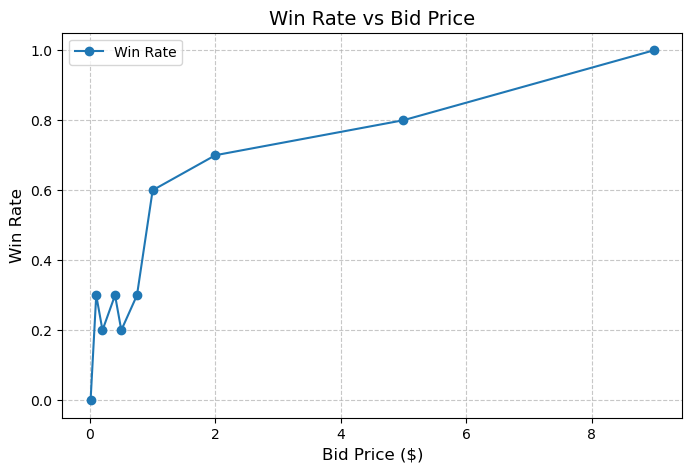

In [4]:
import matplotlib.pyplot as plt

win_data = df[df["win"] == 1].copy()
win_data["win_rate"] = win_data["events"] / df.groupby("bid_price")["events"].transform("sum")

# Plot win rate vs bid price
plt.figure(figsize=(8, 5))
plt.plot(win_data["bid_price"], win_data["win_rate"], marker='o', label='Win Rate')
plt.title("Win Rate vs Bid Price", fontsize=14)
plt.xlabel("Bid Price ($)", fontsize=12)
plt.ylabel("Win Rate", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Here we observe that for bid price <=0.75 the win rate trend isn't following increasing trend as it should for the auction, so I fit a Linear Regression model on these noise points till bid price value 0.75 to make the data noise free for estimation of win rates.

#### Noise Points

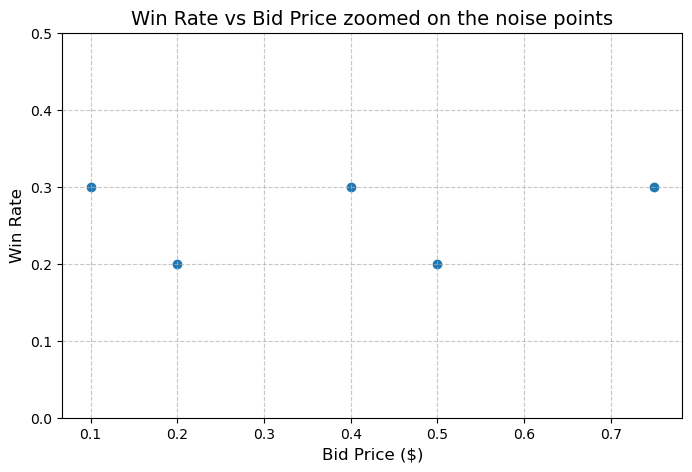

In [5]:

win_data = df[df["win"] == 1].copy()
win_data["win_rate"] = win_data["events"] / df.groupby("bid_price")["events"].transform("sum")
filtered_win_data = win_data[(win_data["bid_price"] > 0.01) & (win_data["bid_price"] <= 0.75)]


# Plot win rate vs bid price
plt.figure(figsize=(8, 5))
plt.scatter(filtered_win_data["bid_price"], filtered_win_data["win_rate"], marker='o', label='Win Rate')
plt.title("Win Rate vs Bid Price zoomed on the noise points", fontsize=14)
plt.xlabel("Bid Price ($)", fontsize=12)
plt.ylabel("Win Rate", fontsize=12)
plt.ylim(0, 0.5)
plt.grid(True, linestyle='--', alpha=0.7)
# plt.legend()
plt.show()

### Lets start with stating my assumptions for the calculations:
1. I assumed each bid price is an auction or you can have one bid price for an auction.
2. All other factors for a bid price like ad slot placement, dimensions or brand/advertiser can be assumed to be same for a bid price.
3. I am making the assumption that there are no errors in the notification system due to overload or high number of requests being captured which could cause a win to not be notified, so for all **no notifications** its not a win.
4. The floor price of the auction is somewhere between 0.01 and 0.1, which means 0.01 bid price is never going to win an auction (as it might be the floor price), we can exclude it for our predictions.
5. Every event is equally important, I assumed all of the bids were tested around the same time (like an A/B test), but there are events that do not follow the first price auction trend, I assumed those are noise points and fit them using a Linear Regression model.

### Steps for getting the answer
1. For each bid price I used group by to consider events for each bid price and calculate win rate by dividing the **win events** by **total events for the bid price**.
2. I used pandas to create dataframe and group by bid price column.
3. Then, I divided number of events with 'win' field value = 1 divided by events with 'win' value 1 + 'win' value 0 (i.e. total events for the bid price).
4. After plotting the win rates calculated with the above formula, we observe win rates not going up with bid price as expected and we made the assumption that all other factors are same, so it might be statistical noise and I tried to fit a Linear Regression model on the noise points.
5. For bid price 0.75 or higher the win probability increases with increase in bid price, so I used original estimates calculated using the formula.

    

Linear Regression fit on noise points

Predictions:  [0.25114504 0.25419847 0.26030534 0.26335878 0.27099237]


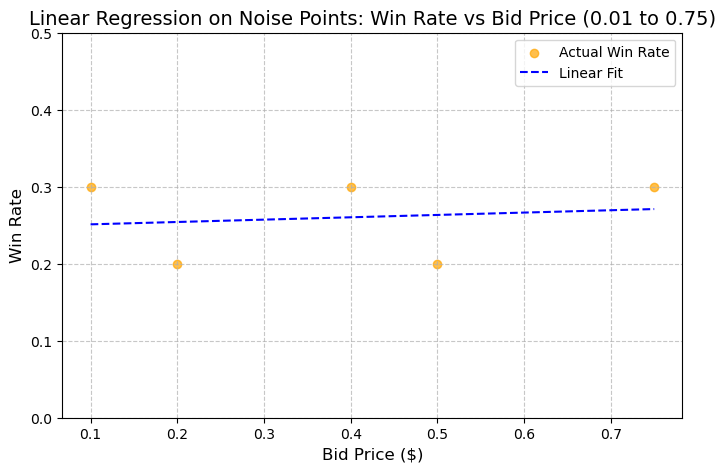

In [7]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data (non-weighted regression)
X = filtered_win_data["bid_price"].values.reshape(-1, 1)
y = filtered_win_data["win_rate"].values

# Fit a simple linear regression model (non-weighted)
model = LinearRegression()
model.fit(X, y)

# Predict using the linear model
y_pred = model.predict(X)
print("Predictions: ",y_pred)

# Plot the non-weighted regression
plt.figure(figsize=(8, 5))
plt.scatter(filtered_win_data["bid_price"], filtered_win_data["win_rate"], color='orange', label='Actual Win Rate', alpha=0.7)
plt.plot(filtered_win_data["bid_price"], y_pred, color='blue', linestyle='--', label='Linear Fit')
plt.title("Linear Regression on Noise Points: Win Rate vs Bid Price (0.01 to 0.75)", fontsize=14)
plt.xlabel("Bid Price ($)", fontsize=12)
plt.ylabel("Win Rate", fontsize=12)
plt.ylim(0, 0.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


### Estimated win rates for the each bid price

In [40]:
win_data["estimated_win_rate"] = win_data["win_rate"]

# Step 3: Update estimated_win_rate for bid_price <= 0.75 using y_pred_filtered
win_data.loc[(win_data["bid_price"] <= 0.75) & (win_data["bid_price"] > 0.01), "estimated_win_rate"] = y_pred

combined_data = win_data.loc[win_data["bid_price"] > 0.01].reset_index(drop=True)

combined_data

,app,bid_price,win,events,win_rate,estimated_win_rate
0,A,0.10,1,3000,0.3,0.251145
1,A,0.20,1,2000000,0.2,0.254198
2,A,0.40,1,300000,0.3,0.260305
3,A,0.50,1,20000,0.2,0.263359
4,A,0.75,1,3000,0.3,0.270992
5,A,1.00,1,600,0.6,0.600000
6,A,2.00,1,70,0.7,0.700000
7,A,5.00,1,8,0.8,0.800000
8,A,9.00,1,1,1.0,1.000000


### Plotting the predicted and calculated win rate values vs bid price

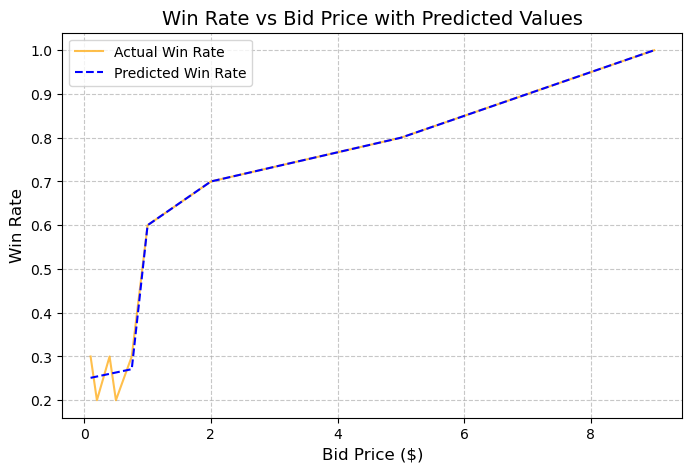

In [41]:
import matplotlib.pyplot as plt

# Plot actual win rates
plt.figure(figsize=(8, 5))
plt.plot(combined_data["bid_price"], combined_data["win_rate"], color='orange', label='Actual Win Rate', alpha=0.7)

# Plot predicted win rates
plt.plot(combined_data["bid_price"], combined_data["estimated_win_rate"], color='blue', linestyle='--', label='Predicted Win Rate')

# Add plot details
plt.title("Win Rate vs Bid Price with Predicted Values", fontsize=14)
plt.xlabel("Bid Price ($)", fontsize=12)
plt.ylabel("Win Rate", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# plt.ylim(0, 0.5)  # Adjust y-axis limits if necessary
plt.show()


### Problem 2 Assumptions
1. I assume $9 is the budget allocated for by the advertiser for each bid, because out of all auctions 9 was the maximum bid, so I assumed the different auctions were meant for an A/B test.
2. Assumed all other factors like advertiser, advertiser budget, ads placement, slot etc. to be same for all auctions/bid prices.



### Goal

We need to **maximise** the revenue which is equal to **(advertiser_payment_per_win * wins - bid_price * wins)** 

So, we need to **minimize** the experession **bid_price * wins**

Based on the question the net revenue is revenue per event which can be written as **(advertiser_payment_per_win - bid_price) * predicted win rate**

In [51]:
advertiser_payment_per_win = 9
df_summary = combined_data

# Calculate net revenue for each bid price
df_summary["net_revenue"] = (advertiser_payment_per_win - df_summary["bid_price"]) * df_summary["estimated_win_rate"]

# Find the optimal bid price with the highest net revenue
optimal_row = df_summary.loc[df_summary["net_revenue"].idxmax()]

# Display the optimal bid price and the associated net revenue
print(f"Calculated initial Optimal Bid Price: {optimal_row['bid_price']:.2f}")
print(f"Net Revenue at Optimal Bid Price: {optimal_row['net_revenue']:.2f}")


Calculated initial Optimal Bid Price: 2.00
Net Revenue at Optimal Bid Price: 4.90


In [44]:
df_summary

,app,bid_price,win,events,win_rate,estimated_win_rate,net_revenue
0,A,0.10,1,3000,0.3,0.251145,2.235191
1,A,0.20,1,2000000,0.2,0.254198,2.236947
2,A,0.40,1,300000,0.3,0.260305,2.238626
3,A,0.50,1,20000,0.2,0.263359,2.238550
4,A,0.75,1,3000,0.3,0.270992,2.235687
5,A,1.00,1,600,0.6,0.600000,4.800000
6,A,2.00,1,70,0.7,0.700000,4.900000
7,A,5.00,1,8,0.8,0.800000,3.200000
8,A,9.00,1,1,1.0,1.000000,0.000000


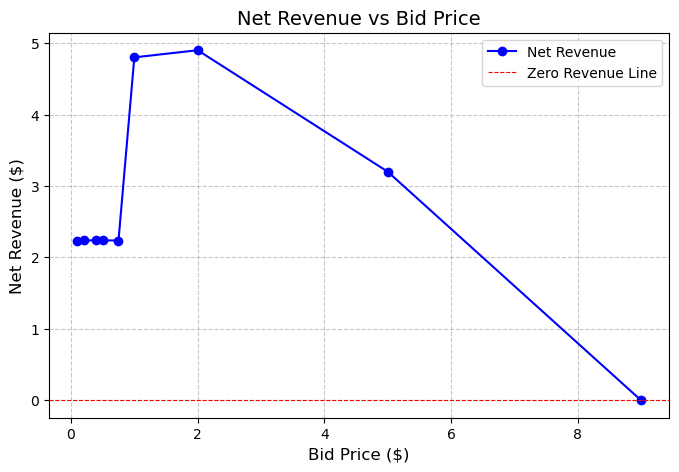

In [45]:
plt.figure(figsize=(8, 5))
plt.plot(df_summary["bid_price"], df_summary["net_revenue"], color='blue', marker='o', label='Net Revenue')
plt.title("Net Revenue vs Bid Price", fontsize=14)
plt.xlabel("Bid Price ($)", fontsize=12)
plt.ylabel("Net Revenue ($)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label="Zero Revenue Line")
plt.legend()
plt.show()

Based on the curve above, it could fit a non-linear distribution curve the net revenue vs bid price.
I tried fitting normal curve and skewed Gaussian curve to the values below and estimate optimal bid price at the peak for revenue. 

**The distribution/curve is bound to change if we take different value for advertiser_payment_per_win, the optimal bid will keep shifting to the right as we increase the advertiser payment per win increases.**

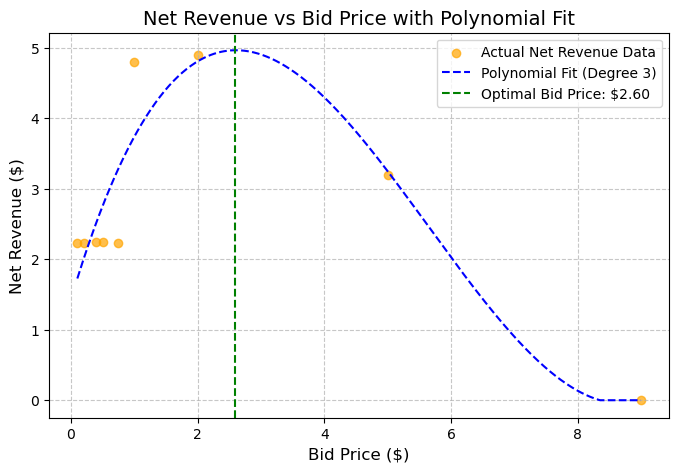

Optimal Bid Price: $2.60
Maximum Net Revenue: $4.96

Polynomial Coefficients:
[ 0.04436226 -0.75184532  3.01335876  1.43259031]

Predicted Net Revenue Values:
   index  bid_price  net_revenue  predicted_net_revenue
0      0       0.10     2.235191               1.726452
1      1       0.20     2.236947               2.005543
2      2       0.40     2.238626               2.520478
3      3       0.50     2.238550               2.756854
4      4       0.75     2.235687               3.288412
5      5       1.00     4.800000               3.738466
6      6       2.00     4.900000               4.806825
7      7       5.00     3.200000               3.248534
8      8       9.00     0.000000              -0.006563


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

# Prepare the data
x_data = df_summary["bid_price"]
y_data = df_summary["net_revenue"]

# Fit a polynomial model of degree 3 (degree = 3 seemed the best fit, 4 was overfitting and 2 was underfitting)
degree = 3
coefficients = np.polyfit(x_data, y_data, degree)
polynomial = np.poly1d(coefficients)

# Generate predictions using the polynomial model
x_fit = np.linspace(x_data.min(), x_data.max(), 500)
#Since the revenue cannot be negative, keeping the value zero when predicted value is negative
y_fit = np.maximum(polynomial(x_fit),0)

# Find the optimal bid price that maximizes the net revenue
optimal_bid_price = x_fit[np.argmax(y_fit)]
optimal_net_revenue = max(y_fit)

# Plot the original data and the polynomial fit
plt.figure(figsize=(8, 5))
plt.scatter(x_data, y_data, color='orange', label='Actual Net Revenue Data', alpha=0.7)
plt.plot(x_fit, y_fit, color='blue', label=f'Polynomial Fit (Degree {degree})', linestyle='--')
plt.axvline(optimal_bid_price, color='green', linestyle='--', label=f'Optimal Bid Price: ${optimal_bid_price:.2f}')
plt.title("Net Revenue vs Bid Price with Polynomial Fit", fontsize=14)
plt.xlabel("Bid Price ($)", fontsize=12)
plt.ylabel("Net Revenue ($)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Print the estimated optimal bid price and net revenue
print(f"Optimal Bid Price: ${optimal_bid_price:.2f}")
print(f"Maximum Net Revenue: ${optimal_net_revenue:.2f}")

# Print the coefficients of the polynomial model
print(f"\nPolynomial Coefficients:\n{coefficients}")

# Predict and print the net revenue values for all bid prices
df_summary["predicted_net_revenue"] = polynomial(df_summary["bid_price"])
print("\nPredicted Net Revenue Values:")
print(df_summary[["bid_price", "net_revenue", "predicted_net_revenue"]].reset_index())


**The data points don't fit really well to a normal distribution but it seems the distribution could fit fit well to a right skewed distribution, so I tried fitting skewed Gaussian distribtuion below.**

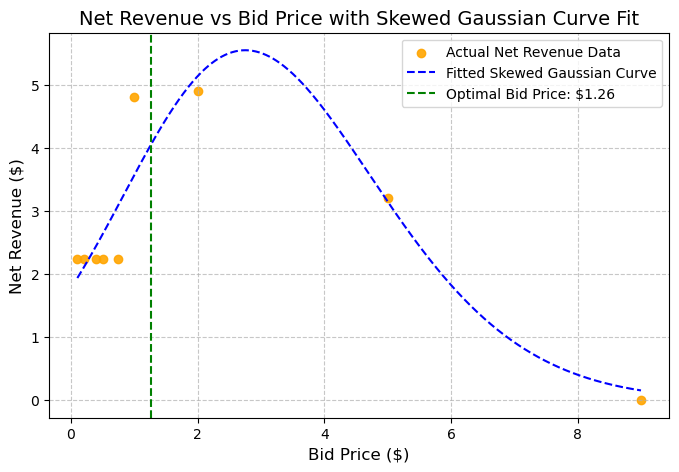

Skewed Gaussian Model Parameters: a = 4.04, mu (Optimal Bid Price) = 1.26, sigma = 2.75, alpha = 1.52

Predicted Net Revenue Values:
   bid_price  net_revenue  predicted_net_revenue
0       0.10     2.235191               1.935513
1       0.20     2.236947               2.100954
2       0.40     2.238626               2.449084
3       0.50     2.238550               2.630229
4       0.75     2.235687               3.096329
5       1.00     4.800000               3.567851
6       2.00     4.900000               5.133096
7       5.00     3.200000               3.146234
8       9.00     0.000000               0.155102


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf  # Import erf from scipy.special

# Define the skewed Gaussian function for fitting (no truncation)
def skewed_gaussian(x, a, mu, sigma, alpha):
    """Skewed Gaussian distribution without truncation."""
    norm_part = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    skew_part = erf(alpha * (x - mu) / (sigma * np.sqrt(2)))
    return a * norm_part * (1 + skew_part)

# Define the skewed Gaussian function with non-negativity for predictions
def skewed_gaussian_nonnegative(x, a, mu, sigma, alpha):
    """Skewed Gaussian distribution with non-negative constraint."""
    return np.maximum(skewed_gaussian(x, a, mu, sigma, alpha), 0)

# Extract data for fitting
x_data = df_summary["bid_price"]
y_data = df_summary["net_revenue"]

# Perform curve fitting (no truncation during fitting)
popt, _ = curve_fit(skewed_gaussian, x_data, y_data, p0=[max(y_data), x_data.mean(), x_data.std(), 1])

# Extract fitted parameters
a, mu, sigma, alpha = popt

# Generate fitted curve
x_fit = np.linspace(x_data.min(), x_data.max(), 500)
y_fit = skewed_gaussian_nonnegative(x_fit, a, mu, sigma, alpha)

# Predict net revenue for each bid price in the dataset
df_summary["predicted_net_revenue"] = skewed_gaussian_nonnegative(df_summary["bid_price"], a, mu, sigma, alpha)

# Plot original data and fitted skewed Gaussian curve
plt.figure(figsize=(8, 5))
plt.scatter(x_data, y_data, color='orange', label='Actual Net Revenue Data', alpha=0.9)
plt.plot(x_fit, y_fit, color='blue', label='Fitted Skewed Gaussian Curve', linestyle='--')
plt.title("Net Revenue vs Bid Price with Skewed Gaussian Curve Fit", fontsize=14)
plt.xlabel("Bid Price ($)", fontsize=12)
plt.ylabel("Net Revenue ($)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=mu, color='green', linestyle='--', label=f'Optimal Bid Price: ${mu:.2f}')
plt.legend()
plt.show()

# Print the fitted parameters and optimal bid price
print(f"Skewed Gaussian Model Parameters: a = {a:.2f}, mu (Optimal Bid Price) = {mu:.2f}, sigma = {sigma:.2f}, alpha = {alpha:.2f}")

# Print the predicted net revenue values for each bid price
print("\nPredicted Net Revenue Values:")
print(df_summary[["bid_price", "net_revenue", "predicted_net_revenue"]].reset_index(drop=True))


Right skewed Gaussian curve seems to capture net revenue data points better, so the **Optimal bid** which is the mode of the distribution is the what we should consider sending in the requests to maximize revenue should be **1.26**